# Lab #4

In [1]:
from PIL import Image, ImageOps
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt


- We load the MNIST dataset, which contains images of handwritten digits. The dataset is split into training and testing sets. We also apply transformations such as converting images to tensor format and normalizing them.

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.MNIST('data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


11.2%

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100.0%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100.0%

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100.0%



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



- Let's print some examples from the dataset.

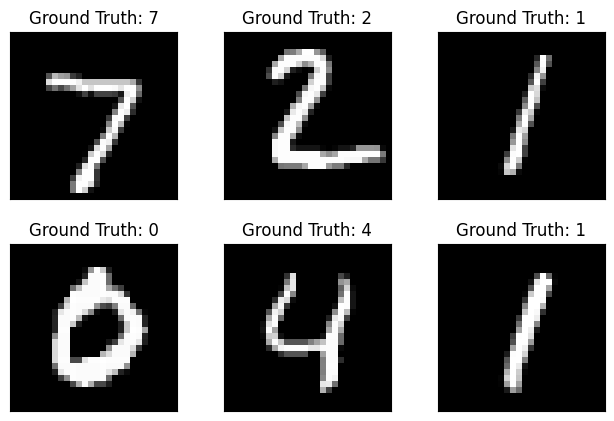

In [3]:
examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)


fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

- Here, we define a simple neural network for digit classification. We use a typical structure with fully connected layers. The training process involves feeding the network with data, calculating loss, and updating model weights.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = Net()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

# Training loop
epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

# Save the model
torch.save(model.state_dict(), 'model.pth')

Training loss: 1.8477768047786216
Training loss: 0.7928161335143962
Training loss: 0.5057009533365399
Training loss: 0.4199844243398099
Training loss: 0.3786978862369493


- After training the model, we evaluate its performance on the test dataset. Metrics like accuracy, precision, and recall are calculated to understand the model's effectiveness in classifying the digits.

In [5]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total}%')


Accuracy of the network on the 10000 test images: 89%


- This section demonstrates a practical application of the trained model. We take a saved image of a handwritten digit, preprocess it to match the input requirements of our model, and then use our model to predict the digit.

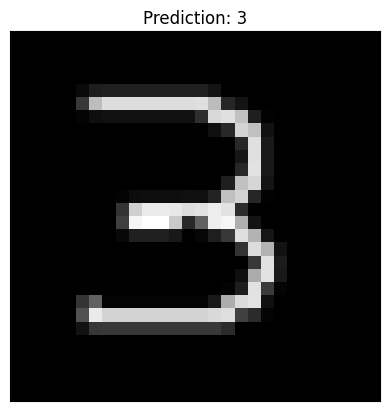

In [7]:
def import_image(image_path, invert=True):
    image = Image.open(image_path).convert('L')

    # Invert image if background is white and foreground is black
    if invert:
        image = ImageOps.invert(image) 
    
    image = image.resize((28, 28))
    return image


def predict_digit(image):
    image = TF.to_tensor(image)
    image = TF.normalize(image, (0.5,), (0.5,))
    image = image.unsqueeze(0)  # Add batch dimension
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    return predicted.item()


# Example usage
image = import_image('data/test.png', invert=True)
predicted_digit = predict_digit(image)

plt.imshow(image, cmap='gray', interpolation='none')
plt.title("Prediction: {}".format(predicted_digit))
plt.xticks([])
plt.yticks([])
plt.show()

## Conclusion

- 